<a href="https://colab.research.google.com/github/mhdSharuk/Kaggle-Ion-Switching/blob/master/Ion_Switching_5_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [2]:
import os
import gc
import pywt
import copy
import numba
import random
import logging
import librosa
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
from scipy import optimize
from sklearn import metrics
from fbprophet import Prophet
from functools import partial
from scipy import stats,signal
from tqdm import tqdm_notebook
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from IPython.display import display,HTML
from tensorflow.keras import backend as K
from sklearn.pipeline import make_pipeline
from keras.initializers import random_normal
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import Callback
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import losses, models, optimizers
from tensorflow.compat.v1.keras.layers import CuDNNLSTM 
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
#from tsfresh.feature_extraction import feature_calculators
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import KFold, train_test_split, GroupKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback
from tensorflow.keras.layers import Dense, Dropout, Add, Conv1D, Flatten,BatchNormalization, Activation, AveragePooling1D,Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, Lambda,Input, Concatenate, UpSampling1D, Multiply,MaxPooling1D,LSTM,TimeDistributed

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20,10)

# Connect to Kaggle CLI

In [4]:
os.chdir('./drive/My Drive/Ion Switching')
os.listdir()

['sample_submission.csv',
 'train.csv.zip',
 'test.csv.zip',
 'sample_submission.csv.zip',
 '.ipynb_checkpoints',
 'test_clean.csv',
 'train_clean.csv',
 'kaggle.json',
 'submission.csv',
 'submission_1.csv',
 'submission_2.csv',
 'submission_5.csv',
 'submission_6.csv',
 'submission_7.csv',
 'submission_8.csv',
 'submission_9.csv',
 'submission_10.csv',
 'submission_11.csv',
 'lgb_cv_0.93933.txt',
 'submission_12.csv',
 'submission_wavenet_13.csv',
 'submission_wavenet_14.csv',
 'submission_15.csv',
 'submission_shift_rfc_16.csv',
 'submission_shift_rfc_random_forest_17.csv',
 'librmm.so',
 'submission_shift_rfc_random_forest_18.csv',
 'Y_test_proba.npy',
 'Y_train_proba.npy',
 'submission_lstm_19.csv',
 'clean-kalman.zip',
 'test_clean_kalman.csv',
 'train_clean_kalman.csv',
 'ion-shifted-rfc-proba.zip',
 'submission_lstm_20.csv',
 'submission_5_fold_lstm_21.csv']

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#!kaggle datasets download -d ragnar123/clean-kalman
!kaggle datasets download -d sggpls/ion-shifted-rfc-proba

 95% 211M/222M [00:02<00:00, 95.1MB/s]
100% 222M/222M [00:02<00:00, 96.3MB/s]


In [0]:
#!unzip clean-kalman.zip
!unzip ion-shifted-rfc-proba

Archive:  ion-shifted-rfc-proba.zip
  inflating: Y_test_proba.npy        
  inflating: Y_train_proba.npy       


# Helper Functions

In [0]:
def get_features(df):
  for x in [1,2,3,4]:
    df[f'sig_shift_pos_{x}'] = df['signal'].shift(x).bfill()
    df[f'sig_shift_neg_{x}'] = df['signal'].shift(-1*x).ffill()
    df[f'sig_pos_diff_{x}'] = df['signal'].diff(x).bfill()
    df[f'sig_neg_diff_{x}'] = df['signal'].diff(-1*x).ffill()

  df['sig_pct_change'] = df['signal'].pct_change().fillna(0)
  for x in [1,2,3,4]:
    df[f'sig_pct_change_pos_{x}'] = df['sig_pct_change'].shift(x).bfill()
    df[f'sig_pct_change_neg_{x}'] = df['sig_pct_change'].shift(-1*x).ffill()
  return df

In [0]:
def get_batches(df):
  df['batch'] =  df.groupby(df.index//50_000).agg('ngroup').astype(np.int16)
  return df

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [0]:
def min_max(df, columns):
  for x in columns:
    df[x] = (df[x].values - np.min(df[x]))/(df[x].max() - df[x].min())
  return df

def std_sc(df,columns):
  for x in columns:
    df[x] = (df[x] - df[x].mean())/df[x].std()
  return df

In [0]:
#For LightGBM
def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

In [0]:
def get_early_prediction(train,test):
  dtrain = {'batch':[],
     'min':[],
     'max':[],
     'range':[],
     'std':[],
     'mean':[],
     'num_states':[],
    }
  for x in train['batch'].unique():
    data = train[train['batch'] == x]
    dtrain['batch'].append(x)
    dtrain['min'].append(data['signal'].min())
    dtrain['max'].append(data['signal'].max())
    dtrain['range'].append(data['signal'].max() - data['signal'].min())
    dtrain['mean'].append(data['signal'].mean())
    dtrain['std'].append(data['signal'].std())
    dtrain['num_states'].append(data['open_channels'].nunique())
  data_train = pd.DataFrame(dtrain)
  train['num_states'] = train['batch'].map({x:y for (x,y) in data_train[['batch','num_states']].values})
  dtest = {'batch':[],
     'min':[],
     'max':[],
     'range':[],
     'std':[],
     'mean':[]
    }
  for x in test['batch'].unique():
    data = test[test['batch'] == x]
    dtest['batch'].append(x)
    dtest['min'].append(data['signal'].min())
    dtest['max'].append(data['signal'].max())
    dtest['mean'].append(data['signal'].mean())
    dtest['std'].append(data['signal'].std())
    dtest['range'].append(data['signal'].max() - data['signal'].min())
  data_test = pd.DataFrame(dtest)
  params = {'learning_rate': 0.09, 
          'max_depth': -1, 
          'num_leaves': 250,
          'metric': 'rmse', 
          'random_state': 7, 
          'n_jobs':-1, 
          'sample_fraction':0.53}

  gc.collect()
  use_cols = ['min','max','range','std','mean']
  x_train,x_val,y_train,y_val = train_test_split(data_train[use_cols],data_train['num_states'],test_size=0.01)
  model = lgb.train(params, lgb.Dataset(x_train, y_train), 2000,  lgb.Dataset(x_val, y_val), verbose_eval=50, early_stopping_rounds=500)
  pred = model.predict(data_test[use_cols])
  round_pred = np.round(np.clip(pred, 2, 10)).astype(int)
  data_test['num_states'] = round_pred
  lgb.plot_importance(model,importance_type='split', max_num_features=30)
  return_dict = {x:y for (x,y) in data_test[['batch','num_states']].values}
  test['num_states'] = test['batch'].map(return_dict)
  return train,test

In [0]:
def reduce_mem_usage(df: pd.DataFrame,verbose: bool = True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if (c_min > np.iinfo(np.int8).min
                        and c_max < np.iinfo(np.int8).max):
                    df[col] = df[col].astype(np.int8)
                elif (c_min > np.iinfo(np.int16).min
                      and c_max < np.iinfo(np.int16).max):
                    df[col] = df[col].astype(np.int16)
                elif (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df

In [0]:
def check(df,a,b):
  return (df[a].values == df[b].values).all()

In [0]:
def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    uthresh = 10
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [0]:
def mean_abs_dev(val):
  return np.mean(np.absolute(val - np.mean(val)))

# Helper Classes

In [0]:
#Eval Metric for Deep Neural Network
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis = 2).reshape(-1)
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis = 2).reshape(-1)
        score = f1_score(self.targets, pred, average = 'macro')
        print(f'   F1 Macro Score: {score:.5f}')

In [0]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, hidden_size, 
                 num_heads = 8, 
                 attention_dropout=.1,
                 trainable=True,
                 name='Attention'):
        
        if hidden_size % num_heads != 0:
            raise ValueError("Hidden size must be evenly divisible by the number of heads.")
            
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.trainable = trainable
        self.attention_dropout = attention_dropout
        self.dense = tf.keras.layers.Dense(self.hidden_size, use_bias=False)
        super(Attention, self).__init__(name=name)

    def split_heads(self, x):
        with tf.name_scope("split_heads"):
            batch_size = tf.shape(x)[0]
            length = tf.shape(x)[1]

            # Calculate depth of last dimension after it has been split.
            depth = (self.hidden_size // self.num_heads)

            # Split the last dimension
            x = tf.reshape(x, [batch_size, length, self.num_heads, depth])

            # Transpose the result
            return tf.transpose(x, [0, 2, 1, 3])
    
    def combine_heads(self, x):
        """Combine tensor that has been split.
        Args:
          x: A tensor [batch_size, num_heads, length, hidden_size/num_heads]
        Returns:
          A tensor with shape [batch_size, length, hidden_size]
        """
        with tf.name_scope("combine_heads"):
            batch_size = tf.shape(x)[0]
            length = tf.shape(x)[2]
            x = tf.transpose(x, [0, 2, 1, 3])  # --> [batch, length, num_heads, depth]
            return tf.reshape(x, [batch_size, length, self.hidden_size])        

    def call(self, inputs):
        """Apply attention mechanism to inputs.
        Args:
          inputs: a tensor with shape [batch_size, length_x, hidden_size]
        Returns:
          Attention layer output with shape [batch_size, length_x, hidden_size]
        """
        # Google developper use tf.layer.Dense to linearly project the queries, keys, and values.
        q = self.dense(inputs)
        k = self.dense(inputs)
        v = self.dense(inputs)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Scale q to prevent the dot product between q and k from growing too large.
        depth = (self.hidden_size // self.num_heads)
        q *= depth ** -0.5
        
        logits = tf.matmul(q, k, transpose_b=True)
        # logits += self.bias
        weights = tf.nn.softmax(logits, name="attention_weights")
        
        if self.trainable:
            weights = tf.nn.dropout(weights, 1.0 - self.attention_dropout)
        
        attention_output = tf.matmul(weights, v)
        attention_output = self.combine_heads(attention_output)
        attention_output = self.dense(attention_output)
        return attention_output
        
    def compute_output_shape(self, input_shape):
        return tf.TensorShape(input_shape)

# Loading the data

In [0]:
train = pd.read_csv('train_clean_kalman.csv')
test = pd.read_csv('test_clean_kalman.csv')
submission = pd.read_csv('sample_submission.csv.zip')

test.reset_index(drop=True,inplace=True)

#### Sampling

In [0]:
train = get_batches(train)
test = get_batches(test)

In [0]:
train_groups = {
    0:[(0,1000000)],
    1:[(1500000,2000000),(3500000,4000000)],
    2:[(2500000,3000000),(4000000,4500000)],
    3:[(1000000,1500000),(3000000,3500000)],
    4:[(2000000,2500000),(4500000,5000000)]
}
train['group'] = -1
for k,v in train_groups.items():
    for l,r in v:
        train.iloc[l:r,-1] = k


test['group'] = -1
test_groups = {
    0:[(0,100000),(300000,400000),(800000,900000),(1000000,2000000)],
    1:[(100000,200000),(900000,1000000)],
    2:[(200000,300000),(600000,700000)],
    3:[(400000,500000)],
    4:[(500000,600000),(700000,800000)]
}
for k,v in test_groups.items():
    for l,r in v:
        test.iloc[l:r,-1] = k

In [0]:
%%capture
append = False
if append:
  test_num_states = {100.0: 2.0,
  101.0: 2.0,
  102.0: 4.0,
  103.0: 4.0,
  104.0: 6.0,
  105.0: 6.0,
  106.0: 2.0,
  107.0: 2.0,
  108.0: 2.0,
  109.0: 2.0,
  110.0: 10.0,
  111.0: 10.0,
  112.0: 6.0,
  113.0: 9.0,
  114.0: 10.0,
  115.0: 10.0,
  116.0: 2.0,
  117.0: 2.0,
  118.0: 4.0,
  119.0: 4.0,
  120.0: 2.0,
  121.0: 2.0,
  122.0: 2.0,
  123.0: 2.0,
  124.0: 3.0,
  125.0: 2.0,
  126.0: 2.0,
  127.0: 2.0,
  128.0: 2.0,
  129.0: 2.0,
  130.0: 2.0,
  131.0: 2.0,
  132.0: 2.0,
  133.0: 2.0,
  134.0: 2.0,
  135.0: 2.0,
  136.0: 3.0,
  137.0: 2.0,
  138.0: 2.0,
  139.0: 2.0}
  test['num_states'] = test['batch'].map(test_num_states)
  train,_ = get_early_prediction(train,test)

In [0]:
train.shape
test.shape

(5000000, 5)

(2000000, 4)

In [0]:
gc.collect()

3855

# Feature Engineering

In [0]:
train = get_features(train)
test = get_features(test)

In [0]:
indicator = []
for x in train.batch.unique():
  if(train[train['batch'] == x]['open_channels'].nunique())>=9:
    indicator.append(x)
len(indicator)

train_indicator = {}
for x in train.batch.unique():
  if x in indicator:
    train_indicator[x] = 1
  else:
    train_indicator[x] = 0

test_indicator = {}
for x in test.batch.unique():
  if x in [10,11,14,15]:
    test_indicator[x] = 1
  else:
    test_indicator[x] = 0


20

In [0]:
train['has_10_states'] = 0
test['has_10_states'] = 0

train['has_10_states'] = train['batch'].map(train_indicator)
test['has_10_states'] = test['batch'].map(test_indicator)

In [0]:
train.head()
test.head()

,time,signal,open_channels,batch,group,sig_shift_pos_1,sig_shift_neg_1,sig_pos_diff_1,sig_neg_diff_1,sig_shift_pos_2,sig_shift_neg_2,sig_pos_diff_2,sig_neg_diff_2,sig_shift_pos_3,sig_shift_neg_3,sig_pos_diff_3,sig_neg_diff_3,sig_shift_pos_4,sig_shift_neg_4,sig_pos_diff_4,sig_neg_diff_4,sig_pct_change,sig_pct_change_pos_1,sig_pct_change_neg_1,sig_pct_change_pos_2,sig_pct_change_neg_2,sig_pct_change_pos_3,sig_pct_change_neg_3,sig_pct_change_pos_4,sig_pct_change_neg_4
0,0.0001,-2.760655,0,0,0,-2.760655,-2.848034,-0.087379,0.087379,-2.760655,-2.424341,0.336315,-0.336315,-2.760655,-3.130037,-0.369381,0.369381,-2.760655,-3.144854,-0.384199,0.384199,0.000000,0.000000,0.031651,0.000000,-0.148767,0.000000,0.291088,0.0,0.004734
1,0.0002,-2.848034,0,0,0,-2.760655,-2.424341,-0.087379,-0.423693,-2.760655,-3.130037,0.336315,0.282003,-2.760655,-3.144854,-0.369381,0.296820,-2.760655,-2.649931,-0.384199,-0.198103,0.031651,0.000000,-0.148767,0.000000,0.291088,0.000000,0.004734,0.0,-0.157375
2,0.0003,-2.424341,0,0,0,-2.848034,-3.130037,0.423693,0.705696,-2.760655,-3.144854,0.336315,0.720513,-2.760655,-2.649931,-0.369381,0.225590,-2.760655,-2.697078,-0.384199,0.272737,-0.148767,0.031651,0.291088,0.000000,0.004734,0.000000,-0.157375,0.0,0.017792
3,0.0004,-3.130037,0,0,0,-2.424341,-3.144854,-0.705696,0.014817,-2.848034,-2.649931,-0.282003,-0.480106,-2.760655,-2.697078,-0.369381,-0.432959,-2.760655,-2.596101,-0.384199,-0.533936,0.291088,-0.148767,0.004734,0.031651,-0.157375,0.000000,0.017792,0.0,-0.037439
4,0.0005,-3.144854,0,0,0,-3.130037,-2.649931,-0.014817,-0.494923,-2.424341,-2.697078,-0.720513,-0.447776,-2.848034,-2.596101,-0.296820,-0.548753,-2.760655,-2.668520,-0.384199,-0.476334,0.004734,0.291088,-0.157375,-0.148767,0.017792,0.031651,-0.037439,0.0,0.027895


,time,signal,batch,group,sig_shift_pos_1,sig_shift_neg_1,sig_pos_diff_1,sig_neg_diff_1,sig_shift_pos_2,sig_shift_neg_2,sig_pos_diff_2,sig_neg_diff_2,sig_shift_pos_3,sig_shift_neg_3,sig_pos_diff_3,sig_neg_diff_3,sig_shift_pos_4,sig_shift_neg_4,sig_pos_diff_4,sig_neg_diff_4,sig_pct_change,sig_pct_change_pos_1,sig_pct_change_neg_1,sig_pct_change_pos_2,sig_pct_change_neg_2,sig_pct_change_pos_3,sig_pct_change_neg_3,sig_pct_change_pos_4,sig_pct_change_neg_4
0,500.0001,-2.651296,0,0,-2.651296,-2.846641,-0.195344,0.195344,-2.651296,-2.853836,-0.202539,0.202539,-2.651296,-2.443806,0.207490,-0.207490,-2.651296,-2.612478,0.038818,-0.038818,0.000000,0.000000,0.073679,0.000000,0.002528,0.000000,-0.143677,0.0,0.069020
1,500.0002,-2.846641,0,0,-2.651296,-2.853836,-0.195344,0.007195,-2.651296,-2.443806,-0.202539,-0.402834,-2.651296,-2.612478,0.207490,-0.234162,-2.651296,-2.569241,0.038818,-0.277400,0.073679,0.000000,0.002528,0.000000,-0.143677,0.000000,0.069020,0.0,-0.016550
2,500.0003,-2.853836,0,0,-2.846641,-2.443806,-0.007195,-0.410030,-2.651296,-2.612478,-0.202539,-0.241357,-2.651296,-2.569241,0.207490,-0.284595,-2.651296,-2.736163,0.038818,-0.117672,0.002528,0.073679,-0.143677,0.000000,0.069020,0.000000,-0.016550,0.0,0.064970
3,500.0004,-2.443806,0,0,-2.853836,-2.612478,0.410030,0.168672,-2.846641,-2.569241,0.402834,0.125435,-2.651296,-2.736163,0.207490,0.292357,-2.651296,-2.779321,0.038818,0.335514,-0.143677,0.002528,0.069020,0.073679,-0.016550,0.000000,0.064970,0.0,0.015773
4,500.0005,-2.612478,0,0,-2.443806,-2.569241,-0.168672,-0.043238,-2.853836,-2.736163,0.241357,0.123685,-2.846641,-2.779321,0.234162,0.166842,-2.651296,-2.840423,0.038818,0.227945,0.069020,-0.143677,-0.016550,0.002528,0.064970,0.073679,0.015773,0.0,0.021985


# Data Split

In [0]:
split_value = train.shape[0] - train.shape[0]*0.1
split_value

In [0]:
use_cols = [x for x in train.columns if x not in ['time', 'open_channels','batch', 'batch_slices', 'group']]
use_cols

['signal',
 'sig_shift_lead_1',
 'sig_shift_lag_1',
 'sig_pct_change_lag_1',
 'sig_pct_change_lead_1',
 'sig_shift_lead_2',
 'sig_shift_lag_2',
 'sig_pct_change_lag_2',
 'sig_pct_change_lead_2',
 'sig_shift_lead_3',
 'sig_shift_lag_3',
 'sig_pct_change_lag_3',
 'sig_pct_change_lead_3',
 'sig_shift_lead_4',
 'sig_shift_lag_4',
 'sig_pct_change_lag_4',
 'sig_pct_change_lead_4',
 'sig_power',
 'batch_sig_power_mean',
 'batch_sig_power_mean_msig',
 'has_10_states']

In [0]:
x_train,x_val,y_train,y_val = train_test_split(train[use_cols],train['open_channels'],test_size=0.15)
gc.collect()
print(f'x_train shape => {x_train.shape}, y_val shape => {y_val.shape}')

In [0]:
gc.collect()

# Model

## Long Short Term Memory (LSTM)

In [0]:
use_cols = [x for x in train.columns if x not in ['time', 'open_channels','batch', 'batch_slices', 'group']]
norm_cols = [x for x in use_cols if x not in ['open_channels','has_10_states']]

In [15]:
SCALE = True
if SCALE:
  train = std_sc(train,norm_cols)
  test = std_sc(test,norm_cols)
for x in norm_cols:
  print('train',x,train[x].mean(),train[x].std())
  print('test',x,test[x].mean(),test[x].std())

train signal 3.493587792391395e-14 0.999999999999989
test signal 8.659270744892922e-15 0.9999999999999813
train sig_shift_pos_1 2.2886475736783042e-14 0.9999999999999851
test sig_shift_pos_1 2.7500393351420628e-14 0.9999999999999947
train sig_shift_neg_1 -1.3087271710787718e-15 1.0000000000000488
test sig_shift_neg_1 -9.440610515554227e-16 0.999999999999995
train sig_pos_diff_1 1.7821522035887937e-18 1.000000000000001
test sig_pos_diff_1 -1.793948323225436e-17 0.9999999999999462
train sig_neg_diff_1 -2.9183322425296865e-18 0.9999999999999843
test sig_neg_diff_1 4.742206627383894e-18 1.0000000000000344
train sig_shift_pos_2 -2.7765500965060142e-14 0.9999999999999669
test sig_shift_pos_2 1.3757074812659197e-14 1.0000000000000042
train sig_shift_neg_2 -8.80271056047377e-15 0.9999999999999597
test sig_shift_neg_2 3.2518650439072874e-14 0.9999999999999286
train sig_pos_diff_2 9.786549348689278e-18 1.0000000000000588
test sig_pos_diff_2 -3.6358416277693095e-19 0.999999999999981
train sig_neg

In [0]:
%%capture
"""CHECK = False
if CHECK:
  train_data = train.loc[train.batch.isin(indicator)][use_cols].drop(columns=['has_10_states']).copy()
  train_data_target = pd.get_dummies(train.loc[train.batch.isin(indicator)]['open_channels'])
  test_data = test[use_cols].drop(columns=['has_10_states']).copy()
else:
  train_data = train[use_cols].copy()
  train_data_target = pd.get_dummies(train['open_channels'])
  test_data = test[use_cols].copy()


train_data['time_slice'] = train_data.groupby(train_data.index//50).agg('ngroup').astype(np.int32) 
train_data_target['time_slice'] = train_data_target.groupby(train_data_target.index//50).agg('ngroup').astype(np.int32)
test_data['time_slice'] = test_data.groupby(test_data.index//50).agg('ngroup').astype(np.int32)

train_data = np.array(list(train_data.groupby('time_slice').apply(lambda x:x[norm_cols].values)))
train_data_target = np.array(list(train_data_target.groupby('time_slice').apply(lambda x:x[np.linspace(0,10,11)].values)))
test_data = np.array(list(test_data.groupby('time_slice').apply(lambda x:x[norm_cols].values)))

train_data = np.array(train_data).reshape((-1,100,27))
train_data_target = np.array(train_data_target).reshape(-1,100,11)
test_data = np.array(test_data).reshape((-1,100,27))

train_data.shape, train_data_target.shape, test_data.shape"""

In [0]:
K.clear_session()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [17]:
train['group'] = train.groupby(train.index//4000).agg('ngroup').astype(np.int32)
test['group'] = test.groupby(test.index//4000).agg('ngroup').astype(np.int32)
group = train['group']

kf = GroupKFold(n_splits=5)
splits = [x for x in kf.split(train, train['open_channels'], group)]
new_splits = []
for sp in splits:
    new_split = []
    new_split.append(np.unique(group[sp[0]]))
    new_split.append(np.unique(group[sp[1]]))
    new_split.append(sp[1])    
    new_splits.append(new_split)


cols = [x for x in train.columns if x not in ['group','time','open_channels','batch']]
tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)
tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
target_cols = ['target_'+str(i) for i in range(11)]

train_data_target = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
train_data = np.array(list(train.groupby('group').apply(lambda x: x[use_cols].values)))
test_data = np.array(list(test.groupby('group').apply(lambda x: x[use_cols].values)))

train_data.shape, train_data_target.shape, test_data.shape

((1250, 4000, 26), (1250, 4000, 11), (500, 4000, 26))

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=10,verbose=1)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.25,patience=10,verbose=1)

In [0]:
def lr_schedule(epoch):
    if epoch < 40:
        lr = LR
    elif epoch < 50:
        lr = LR / 3
    elif epoch < 60:
        lr = LR / 6
    elif epoch < 75:
        lr = LR / 9
    elif epoch < 85:
        lr = LR / 12
    elif epoch < 100:
        lr = LR / 15
    else:
        lr = LR / 50
    return lr

LR = 0.001
cb_lr_schedule = LearningRateScheduler(lr_schedule)
opt = optimizers.Adam(lr=LR,decay=1e-6)

In [34]:
LR = 0.001
opt = optimizers.Adam(lr=LR,decay=1e-6)
model = Sequential()
model.add(CuDNNLSTM(200, return_sequences=True, input_shape=train_data.shape[1:]))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(100, return_sequences=True))
model.add(Dropout(0.1))
model.add(CuDNNLSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(25, activation='relu')))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(11,activation='softmax')))
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 4000, 200)         182400    
_________________________________________________________________
dropout (Dropout)            (None, 4000, 200)         0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 4000, 100)         120800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4000, 100)         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 4000, 50)          30400     
_________________________________________________________________
time_distributed (TimeDistri (None, 4000, 25)          1275      
_________________________________________________________________
batch_normalization (BatchNo (None, 4000, 25)          1

In [41]:
seed_everything(42)
oof_ = np.zeros((len(train), 11)) 
preds_ = np.zeros((len(test), 11))
for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
  print(f'On Fold :{n_fold}')
  train_x, train_y = train_data[tr_idx], train_data_target[tr_idx]
  valid_x, valid_y = train_data[val_idx], train_data_target[val_idx]
  print(f'Our training dataset shape is {train_x.shape}')
  print(f'Our validation dataset shape is {valid_x.shape}')
  model.fit(train_x,train_y,
            epochs=120,
            callbacks=[early_stopping,lr_schedule,MacroF1(model,valid_x,valid_y)],
            batch_size=8,
            validation_data=(valid_x,valid_y))
  preds_f = model.predict(valid_x)
  f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro')
  print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
  preds_f = preds_f.reshape(-1, preds_f.shape[-1])
  oof_[val_orig_idx,:] += preds_f
  te_preds = model.predict(test_data)
  te_preds = te_preds.reshape(-1, te_preds.shape[-1])
  preds_ += te_preds
preds_ = preds_ / 5
f1_score_ = f1_score(np.argmax(train_data_target, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') 
print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')

On Fold :0
Our training dataset shape is (1000, 4000, 26)
Our validation dataset shape is (250, 4000, 26)
Epoch 1/120
125/125 [==============================] - 46s 366ms/step - loss: 0.5398 - accuracy: 0.8211 - val_loss: 0.3963 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 2/120
125/125 [==============================] - 41s 331ms/step - loss: 0.2657 - accuracy: 0.9181 - val_loss: 0.2120 - val_accuracy: 0.9339 - lr: 0.0010
Epoch 3/120
125/125 [==============================] - 41s 331ms/step - loss: 0.4494 - accuracy: 0.8514 - val_loss: 0.5318 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 4/120
125/125 [==============================] - 41s 332ms/step - loss: 0.3281 - accuracy: 0.8929 - val_loss: 0.2131 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 5/120
125/125 [==============================] - 41s 332ms/step - loss: 0.1919 - accuracy: 0.9367 - val_loss: 0.2011 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 6/120
125/125 [==============================] - 41s 332ms/step - loss: 0.1672 - accuracy: 0.

Training fold 1 completed. macro f1 score : 0.93246
On Fold :1
Our training dataset shape is (1000, 4000, 26)
Our validation dataset shape is (250, 4000, 26)
Epoch 1/120
125/125 [==============================] - 41s 331ms/step - loss: 0.0951 - accuracy: 0.9642 - val_loss: 0.0857 - val_accuracy: 0.9691 - lr: 2.5000e-04
Epoch 2/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0938 - accuracy: 0.9645 - val_loss: 0.0856 - val_accuracy: 0.9691 - lr: 2.5000e-04
Epoch 3/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0944 - accuracy: 0.9642 - val_loss: 0.0857 - val_accuracy: 0.9690 - lr: 2.5000e-04
Epoch 4/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0941 - accuracy: 0.9645 - val_loss: 0.0861 - val_accuracy: 0.9689 - lr: 2.5000e-04
Epoch 5/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0932 - accuracy: 0.9646 - val_loss: 0.0857 - val_accuracy: 0.9690 - lr: 2.5000e-04
Epoch 6/120
125/125 [======

Training fold 2 completed. macro f1 score : 0.93826
On Fold :2
Our training dataset shape is (1000, 4000, 26)
Our validation dataset shape is (250, 4000, 26)
Epoch 1/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0924 - accuracy: 0.9650 - val_loss: 0.0876 - val_accuracy: 0.9681 - lr: 6.2500e-05
Epoch 2/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0918 - accuracy: 0.9651 - val_loss: 0.0876 - val_accuracy: 0.9682 - lr: 6.2500e-05
Epoch 3/120
125/125 [==============================] - 42s 332ms/step - loss: 0.0920 - accuracy: 0.9652 - val_loss: 0.0878 - val_accuracy: 0.9681 - lr: 6.2500e-05
Epoch 4/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0920 - accuracy: 0.9651 - val_loss: 0.0881 - val_accuracy: 0.9681 - lr: 6.2500e-05
Epoch 5/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0915 - accuracy: 0.9651 - val_loss: 0.0876 - val_accuracy: 0.9682 - lr: 6.2500e-05
Epoch 6/120
125/125 [======

Training fold 3 completed. macro f1 score : 0.93629
On Fold :3
Our training dataset shape is (1000, 4000, 26)
Our validation dataset shape is (250, 4000, 26)
Epoch 1/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0913 - accuracy: 0.9654 - val_loss: 0.0888 - val_accuracy: 0.9676 - lr: 1.5625e-05
Epoch 2/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0907 - accuracy: 0.9655 - val_loss: 0.0887 - val_accuracy: 0.9675 - lr: 1.5625e-05
Epoch 3/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0911 - accuracy: 0.9655 - val_loss: 0.0889 - val_accuracy: 0.9675 - lr: 1.5625e-05
Epoch 4/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0911 - accuracy: 0.9655 - val_loss: 0.0889 - val_accuracy: 0.9675 - lr: 1.5625e-05
Epoch 5/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0904 - accuracy: 0.9656 - val_loss: 0.0887 - val_accuracy: 0.9675 - lr: 1.5625e-05
Epoch 6/120
125/125 [======

Training fold 4 completed. macro f1 score : 0.93709
On Fold :4
Our training dataset shape is (1000, 4000, 26)
Our validation dataset shape is (250, 4000, 26)
Epoch 1/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0913 - accuracy: 0.9654 - val_loss: 0.0887 - val_accuracy: 0.9678 - lr: 3.9063e-06
Epoch 2/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0908 - accuracy: 0.9654 - val_loss: 0.0887 - val_accuracy: 0.9677 - lr: 3.9063e-06
Epoch 3/120
125/125 [==============================] - 42s 332ms/step - loss: 0.0909 - accuracy: 0.9655 - val_loss: 0.0887 - val_accuracy: 0.9677 - lr: 3.9063e-06
Epoch 4/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0910 - accuracy: 0.9654 - val_loss: 0.0887 - val_accuracy: 0.9677 - lr: 3.9063e-06
Epoch 5/120
125/125 [==============================] - 41s 332ms/step - loss: 0.0907 - accuracy: 0.9655 - val_loss: 0.0887 - val_accuracy: 0.9677 - lr: 3.9063e-06
Epoch 6/120
125/125 [======

Training fold 5 completed. macro f1 score : 0.93765
Training completed. oof macro f1 score : 0.93635


In [42]:
submission['open_channels'] = np.argmax(preds_, axis = 1).astype(int)
submission['open_channels'].value_counts()
submission.to_csv('submission_5_fold_lstm_22.csv', index=False, float_format='%.4f')

1     1213516
2      204899
8       96614
3       91210
7       80363
9       77447
4       73058
10      62556
6       52118
5       43671
0        4548
Name: open_channels, dtype: int64

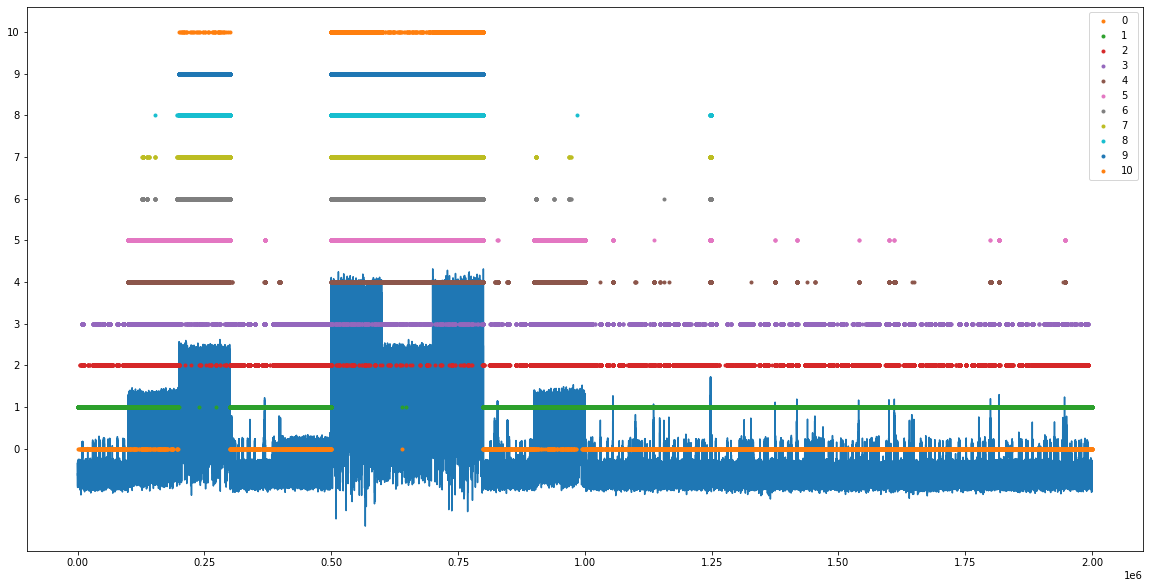

In [47]:
plt.plot(test['signal'])
for x in np.sort(submission['open_channels'].unique()):
  _=plt.plot(submission[submission['open_channels'] == x]['open_channels'],'.',label=x)
_=plt.legend()
_=plt.yticks(np.linspace(0,10,11))

In [45]:
!kaggle competitions submit -c liverpool-ion-switching -f submission_5_fold_lstm_22.csv -m "0.93635"

100% 21.0M/21.0M [00:02<00:00, 9.12MB/s]
Successfully submitted to University of Liverpool - Ion Switching

In [0]:
#opt = optimizers.Adam(lr=LR,decay=1e-5)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#history = model.fit(train_data,train_data_target,epochs=120,batch_size=8,validation_split=0.2,callbacks=[cb_lr_schedule])

In [0]:
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model

def get_base_model(input_len, fsize):
  input_seq = Input(shape=(input_len, 19))
  nb_filters = 10
  convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
  processed = GlobalMaxPooling1D()(convolved)
  compressed = Dense(50, activation="tanh")(processed)
  compressed = Dropout(0.3)(compressed)
  model = Model(inputs=input_seq, outputs=compressed)
  return model
  
def main_model(inputs_lens = [512, 1024, 3480], fsizes = [8,16,24]):
  input_smallseq = Input(shape=(inputs_lens[0], 19))
  input_medseq = Input(shape=(inputs_lens[1] , 19))
  input_origseq = Input(shape=(inputs_lens[2], 19))
  base_net_small = get_base_model(inputs_lens[0], fsizes[0])
  base_net_med = get_base_model(inputs_lens[1], fsizes[1])
  base_net_original = get_base_model(inputs_lens[2], fsizes[2])
  embedding_small = base_net_small(input_smallseq)
  embedding_med = base_net_med(input_medseq)
  embedding_original = base_net_original(input_origseq)
  merged = Concatenate()([embedding_small, embedding_med, embedding_original])
  out = Dense(1, activation='sigmoid')(merged)
  model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
  return model

## Facebook Prophet

In [0]:
prophet = Prophet()
prophet_data = train.rename(columns={'signal':'ds','open_channels':'y'})
prophet.fit(prophet_data[['ds','y']])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
;prophet_test = train[train['batch'] == 47].rename(columns={'signal':'ds'}).drop(columns=['open_channels']).head(200).tail(100)
prophet_test.head()

,time,ds,batch
2350100,235.0101,5.457536,47
2350101,235.0102,5.873407,47
2350102,235.0103,4.103076,47
2350103,235.0104,2.964446,47
2350104,235.0105,1.162220,47


In [0]:
preds = prophet.predict(prophet_test)['yhat']

In [0]:
preds = np.round(np.clip(0,10,preds)).astype(np.int32)

In [0]:
true_ = train[train['batch'] == 47].rename(columns={'signal':'ds'}).head(200).tail(100)['open_channels']
f1_score(preds,true_,average='macro')

0.11281483374506629

## Random Forest

In [0]:
train = random_forest_feat(train)
test = random_forest_feat(test)

In [0]:
test_pred = np.zeros((test.shape[0]),dtype=np.int8)
for g in [0,1,2,3,4]:
    print('Infering group %i'%g)
    
    # TRAIN DATA
    data = train.loc[train.group==g]
    x_train = np.zeros((len(data)-6,7))
    x_train[:,0] = 0.25*data.signal[:-6]
    x_train[:,1] = 0.5*data.signal[1:-5]
    x_train[:,2] = 1.0*data.signal[2:-4]
    x_train[:,3] = 4.0*data.signal[3:-3]
    x_train[:,4] = 1.0*data.signal[4:-2]
    x_train[:,5] = 0.5*data.signal[5:-1]
    x_train[:,6] = 0.25*data.signal[6:]
    y_train = data.open_channels[3:].values

    # TEST DATA
    data = test.loc[test.group==g]
    x_test = np.zeros((len(data)-6,7))
    x_test[:,0] = 0.25*data.signal[:-6]
    x_test[:,1] = 0.5*data.signal[1:-5]
    x_test[:,2] = 1.0*data.signal[2:-4]
    x_test[:,3] = 4.0*data.signal[3:-3]
    x_test[:,4] = 1.0*data.signal[4:-2]
    x_test[:,5] = 0.5*data.signal[5:-1]
    x_test[:,6] = 0.25*data.signal[6:]

    

Infering group 0
Infering group 1
Infering group 2
Infering group 3
Infering group 4


In [0]:
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
            n_estimators=150,
            max_depth=19,
            max_features=train[use_cols].shape[1],
            random_state=42,
            n_jobs=10,
            verbose=2
        )
model = rf.fit(train[use_cols],train['open_channels'])

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 150building tree 2 of 150building tree 3 of 150building tree 4 of 150

building tree 5 of 150
building tree 6 of 150

building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150

building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150


[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 16.8min


building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72

[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed: 83.4min finished


In [0]:
preds = model.predict(test[use_cols])

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   19.4s finished


## LightGBM Algorithm

### GroupKFold 

In [0]:
predictions = 0
splits = GroupKFold(n_splits = 5)
for i, (train_idx, val_idx) in enumerate(splits.split(train[use_cols],train['open_channels'],groups=train['batch'])):
  print(f'On fold {i}')
  cols = [x for x in use_cols if x not in ['batch']]
  
  x_train,x_val = train[cols].iloc[train_idx],train[cols].iloc[val_idx]
  y_train,y_val = train['open_channels'].iloc[train_idx],train['open_channels'].iloc[val_idx]
  
  train_data = lgb.Dataset(x_train,y_train)
  val_data = lgb.Dataset(x_val, y_val)

  model = lgb.train(params, train_data, 2000,  val_data, verbose_eval=50, early_stopping_rounds=500, feval=MacroF1Metric)
  preds = model.predict(test[cols],num_iteration=model.best_iteration)
  predictions += preds

  del x_train,x_val,y_train,y_val,train_data,val_data
  gc.collect()
predictions /= 5

### One Fold

In [0]:
params = {'learning_rate': 0.09, 
          'max_depth': -1, 
          'num_leaves': 250,
          'metric': 'rmse', 
          'random_state': 7, 
          'n_jobs':-1, 
          'sample_fraction':0.53}

gc.collect()

0

In [0]:
model = lgb.train(params, lgb.Dataset(x_train, y_train), 2000,  lgb.Dataset(x_val, y_val), verbose_eval=50, early_stopping_rounds=500, feval=MacroF1Metric)

Training until validation scores don't improve for 500 rounds.
[50]	valid_0's rmse: 0.159627	valid_0's MacroF1Metric: 0.933547
[100]	valid_0's rmse: 0.157512	valid_0's MacroF1Metric: 0.93458
[150]	valid_0's rmse: 0.157538	valid_0's MacroF1Metric: 0.934386
[200]	valid_0's rmse: 0.157576	valid_0's MacroF1Metric: 0.934521
[250]	valid_0's rmse: 0.157592	valid_0's MacroF1Metric: 0.934466
[300]	valid_0's rmse: 0.157621	valid_0's MacroF1Metric: 0.934504
[350]	valid_0's rmse: 0.157653	valid_0's MacroF1Metric: 0.934774
[400]	valid_0's rmse: 0.157685	valid_0's MacroF1Metric: 0.934684
[450]	valid_0's rmse: 0.157731	valid_0's MacroF1Metric: 0.934726
[500]	valid_0's rmse: 0.157776	valid_0's MacroF1Metric: 0.934665
[550]	valid_0's rmse: 0.157799	valid_0's MacroF1Metric: 0.934665
Early stopping, best iteration is:
[88]	valid_0's rmse: 0.157497	valid_0's MacroF1Metric: 0.93452


In [0]:
SAVE_MODEL = True
if SAVE_MODEL:
  model.save_model('lgb_cv_0.93933.txt')

In [0]:
preds = model.predict(test[use_cols], num_iteration=model.best_iteration)

## Unet Architecture

In [0]:
K.clear_session()
model = Unet()
print(model.summary())

learning_rate=0.005
n_epoch=60
batch_size=32

lr_schedule = LearningRateScheduler(lrs)

#classifier
model.compile(loss=categorical_crossentropy, 
              optimizer=Adam(lr=learning_rate), 
              metrics=["accuracy"])

hist = model_fit(model, train_input, train_target, val_input, val_target, n_epoch, batch_size)

## WaveNet

In [0]:
def Classifier(shape_):
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    print(f'inp : {inp}')
    x = wave_block(inp, 16, 3, 12)
    x = wave_block(x, 32, 3, 8)
    x = wave_block(x, 64, 3, 4)
    x = wave_block(x, 128, 3, 1)
    
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    print(f'Input Shape : {model.input_shape}')
    opt = Adam(lr = LR)
    #opt = tfa.optimizers.SWA(opt)
    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    print(model.summary())
    return model

# function that decrease the learning as epochs increase (i also change this part of the code)
def lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    else:
        lr = LR / 100
    return lr

# class to get macro f1 score. This is not entirely necessary but it's fun to check f1 score of each epoch (be carefull, if you use this function early stopping callback will not work)
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis = 2).reshape(-1)
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis = 2).reshape(-1)
        score = f1_score(self.targets, pred, average = 'macro')
        print(f'F1 Macro Score: {score:.5f}')

In [0]:
def grouping(df):
  df['group'] = df.groupby(df.index//4000,sort=False)['signal'].agg(['ngroup']).values
  df['group'] = df.group.astype(np.uint16)
  return df

In [0]:
def get_features(df):
  df['batch_slice_roll10_std'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(10).std())
  df['batch_slice_roll20_std'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(20).std())
  df['batch_slice_roll30_std'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(30).std())
  df['batch_slice_roll10_var'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(10).var())
  df['batch_slice_roll20_var'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(20).var())
  df['batch_slice_roll30_var'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(30).var())
  df['batch_slice_roll10_mean'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(10).mean())
  df['batch_slice_roll20_mean'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(20).mean())
  df['batch_slice_roll30_mean'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(30).mean())
  df['batch_slice_roll10_max'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(10).max())
  df['batch_slice_roll20_max'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(20).max())
  df['batch_slice_roll30_max'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(30).max())
  df['batch_slice_roll10_min'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(10).min())
  df['batch_slice_roll20_min'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(20).min())
  df['batch_slice_roll30_min'] = df.groupby('batch_slices')['signal'].transform(lambda x:pd.Series(x).rolling(30).min())
  df['batch_slice_roll10_range'] = df['batch_slice_roll10_max'] - df['batch_slice_roll10_min']
  df['batch_slice_roll20_range'] = df['batch_slice_roll20_max'] - df['batch_slice_roll20_min']
  df['batch_slice_roll30_range'] = df['batch_slice_roll30_max'] - df['batch_slice_roll30_min']
  return df

In [0]:
def norm(df):
  for x in [x for x in df.columns if x not in ['group','open_channels','time','num_states','batch','batch_slices']]:
    min_ = df[x].min(axis=0)
    max_ = df[x].max(axis=0)
    df[x] = (df[x] - min_)/(max_ - min_)
  return df

In [0]:
train = pd.read_csv('train_clean_kalman.csv')
test = pd.read_csv('test_clean_kalman.csv')
submission = pd.read_csv('sample_submission.csv.zip')

In [0]:
pipe = DataPipeLine()
train = pipe.get_batch(train)
test = pipe.get_batch(test)

In [0]:
train = grouping(train)
test = grouping(test)

Training until validation scores don't improve for 500 rounds.
[50]	valid_0's rmse: 0.00948205
[100]	valid_0's rmse: 0.00912135
[150]	valid_0's rmse: 0.0317013
[200]	valid_0's rmse: 0.0550278
[250]	valid_0's rmse: 0.0707167
[300]	valid_0's rmse: 0.0826354
[350]	valid_0's rmse: 0.0938618
[400]	valid_0's rmse: 0.0980254
[450]	valid_0's rmse: 0.105739
[500]	valid_0's rmse: 0.110259
[550]	valid_0's rmse: 0.112986
Early stopping, best iteration is:
[87]	valid_0's rmse: 0.0001708


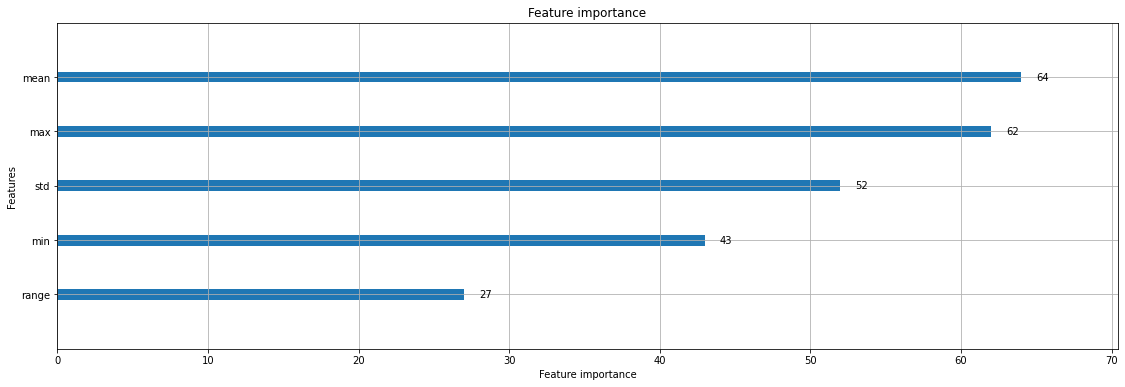

In [0]:
train,test = get_early_prediction(train,test)

In [0]:
train = get_features(train)
test = get_features(test)

In [0]:
train = norm(train)
test = norm(test)

In [0]:
train.describe()
test.describe()

,time,signal,open_channels,batch,group,num_states,batch_slice_roll10_std,batch_slice_roll20_std,batch_slice_roll30_std,batch_slice_roll10_var,batch_slice_roll20_var,batch_slice_roll30_var,batch_slice_roll10_mean,batch_slice_roll20_mean,batch_slice_roll30_mean,batch_slice_roll10_max,batch_slice_roll20_max,batch_slice_roll30_max,batch_slice_roll10_min,batch_slice_roll20_min,batch_slice_roll30_min,batch_slice_roll10_range,batch_slice_roll20_range,batch_slice_roll30_range
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,4.991000e+06,4.981000e+06,4.971000e+06,4.991000e+06,4.981000e+06,4.971000e+06,4.991000e+06,4.981000e+06,4.971000e+06,4.991000e+06,4.981000e+06,4.971000e+06,4.991000e+06,4.981000e+06,4.971000e+06,4.991000e+06,4.981000e+06,4.971000e+06
mean,2.500001e+02,4.080354e-01,2.726043e+00,4.949999e+01,6.245000e+02,4.820000e+00,1.175916e-01,1.363476e-01,1.471268e-01,2.242574e-02,3.125659e-02,3.828431e-02,3.541544e-01,3.223954e-01,3.015726e-01,3.460113e-01,3.575005e-01,3.649569e-01,3.864966e-01,3.680960e-01,3.598078e-01,1.748988e-01,2.109475e-01,2.282431e-01
std,1.443376e+02,1.731953e-01,2.665051e+00,2.886607e+01,3.608438e+02,2.987909e+00,8.464416e-02,9.671180e-02,1.062616e-01,3.398883e-02,4.055737e-02,4.639604e-02,2.101878e-01,2.202706e-01,2.302172e-01,2.456687e-01,2.597327e-01,2.675085e-01,1.614062e-01,1.520208e-01,1.471322e-01,1.254165e-01,1.500132e-01,1.661437e-01
min,1.000000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.250001e+02,2.560607e-01,1.000000e+00,2.475000e+01,3.120000e+02,2.000000e+00,4.292514e-02,4.209613e-02,3.840646e-02,2.452140e-03,3.004358e-03,3.204240e-03,1.644060e-01,1.227190e-01,9.302422e-02,1.404848e-01,1.362806e-01,1.352456e-01,2.266545e-01,2.199298e-01,2.187609e-01,6.725083e-02,7.371293e-02,7.221630e-02
50%,2.500000e+02,3.806188e-01,2.000000e+00,4.950000e+01,6.245000e+02,4.000000e+00,1.088345e-01,1.262821e-01,1.336942e-01,1.328405e-02,1.931892e-02,2.329700e-02,3.327503e-01,3.025729e-01,2.823018e-01,3.457822e-01,3.509961e-01,3.537368e-01,3.396161e-01,3.239426e-01,3.212072e-01,1.521841e-01,1.736753e-01,1.822765e-01
75%,3.750000e+02,5.403648e-01,4.000000e+00,7.400000e+01,9.370000e+02,6.000000e+00,1.658441e-01,1.980436e-01,2.170580e-01,2.955693e-02,4.407476e-02,5.507120e-02,5.203709e-01,4.990732e-01,4.878719e-01,5.554434e-01,5.708526e-01,5.770584e-01,5.064888e-01,4.873768e-01,4.601131e-01,2.499022e-01,3.003234e-01,3.389818e-01
max,5.000000e+02,1.000000e+00,1.000000e+01,9.900000e+01,1.249000e+03,1.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


,time,signal,batch,group,num_states,batch_slice_roll10_std,batch_slice_roll20_std,batch_slice_roll30_std,batch_slice_roll10_var,batch_slice_roll20_var,batch_slice_roll30_var,batch_slice_roll10_mean,batch_slice_roll20_mean,batch_slice_roll30_mean,batch_slice_roll10_max,batch_slice_roll20_max,batch_slice_roll30_max,batch_slice_roll10_min,batch_slice_roll20_min,batch_slice_roll30_min,batch_slice_roll10_range,batch_slice_roll20_range,batch_slice_roll30_range
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,1.996400e+06,1.992400e+06,1.988400e+06,1.996400e+06,1.992400e+06,1.988400e+06,1.996400e+06,1.992400e+06,1.988400e+06,1.996400e+06,1.992400e+06,1.988400e+06,1.996400e+06,1.992400e+06,1.988400e+06,1.996400e+06,1.992400e+06,1.988400e+06
mean,6.000001e+02,3.012103e-01,1.195000e+02,2.495000e+02,3.750000e+00,1.191040e-01,1.369275e-01,1.290481e-01,2.666212e-02,4.114670e-02,3.908565e-02,2.130505e-01,1.696633e-01,1.679608e-01,2.036175e-01,2.058649e-01,2.111060e-01,2.794275e-01,2.740865e-01,2.679150e-01,1.276733e-01,1.345486e-01,1.455808e-01
std,5.773504e+01,1.620091e-01,1.154340e+01,1.443373e+02,2.467287e+00,1.027773e-01,1.298545e-01,1.277912e-01,4.593586e-02,6.757486e-02,6.337742e-02,1.995798e-01,2.137186e-01,2.140694e-01,2.306383e-01,2.442853e-01,2.506702e-01,1.453750e-01,1.387967e-01,1.323803e-01,1.088038e-01,1.261947e-01,1.419849e-01
min,5.000001e+02,0.000000e+00,1.000000e+02,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.500001e+02,1.944610e-01,1.097500e+02,1.247500e+02,2.000000e+00,5.097809e-02,4.826944e-02,4.051324e-02,3.579730e-03,4.839826e-03,4.110326e-03,8.111174e-02,2.785994e-02,2.556016e-02,4.655078e-02,3.903943e-02,3.975648e-02,1.893534e-01,1.899024e-01,1.885436e-01,5.620643e-02,5.039760e-02,5.036889e-02
50%,6.000000e+02,2.140872e-01,1.195000e+02,2.495000e+02,3.000000e+00,6.824371e-02,6.364135e-02,5.282093e-02,5.946517e-03,7.305959e-03,5.967830e-03,9.139691e-02,3.675213e-02,3.358518e-02,6.392428e-02,5.546235e-02,5.565808e-02,2.013682e-01,2.008356e-01,1.988580e-01,7.696584e-02,6.980326e-02,6.977516e-02
75%,6.500000e+02,3.743221e-01,1.292500e+02,3.742500e+02,4.000000e+00,1.716970e-01,2.022147e-01,1.905940e-01,3.236352e-02,4.970464e-02,4.612461e-02,3.186608e-01,2.865749e-01,2.871187e-01,3.516052e-01,3.571113e-01,3.623799e-01,3.242982e-01,3.130148e-01,3.069200e-01,1.700034e-01,1.743993e-01,1.876201e-01
max,7.000000e+02,1.000000e+00,1.390000e+02,4.990000e+02,1.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [0]:
feats

['signal',
 'num_states',
 'batch_slice_roll10_std',
 'batch_slice_roll20_std',
 'batch_slice_roll30_std',
 'batch_slice_roll10_var',
 'batch_slice_roll20_var',
 'batch_slice_roll30_var',
 'batch_slice_roll10_mean',
 'batch_slice_roll20_mean',
 'batch_slice_roll30_mean',
 'batch_slice_roll10_max',
 'batch_slice_roll20_max',
 'batch_slice_roll30_max',
 'batch_slice_roll10_min',
 'batch_slice_roll20_min',
 'batch_slice_roll30_min',
 'batch_slice_roll10_range',
 'batch_slice_roll20_range',
 'batch_slice_roll30_range']

In [0]:
feats = ['signal'] #[x for x in test.columns if x not in ['time','group','batch','batch_slices','batch','batch_slices']]
tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)
tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
target_cols = ['target_'+str(i) for i in range(11)]
train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values)))
train_ = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
test_ = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))
print(train_tr.shape)
print(train_.shape)
print(test_.shape)

(1250,)
(1250,)
(500,)


In [0]:
train_.shape

(1250,)

In [0]:
train_x,val_x,train_y,val_y = train_test_split(train_,train_tr,test_size=0.15)

In [0]:
LR = 0.001
nn_epochs = 100
nn_batch_size = 16

In [0]:
K.clear_session()
gc.collect()
shape_ = (None, train_x.shape[2]) 
print(f'Shape : {shape_}')
model = Classifier(shape_)
print(f'Model Input shape : {model.input_shape}')
print(f'Model Output shape : {model.output_shape}')

382889

Shape : (None, 3)
inp : Tensor("input_1:0", shape=(None, None, 3), dtype=float32)
Input Shape : (None, None, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 16)     64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     784         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 16)     784         conv1d[0][0]    

In [0]:
cb_lr_schedule = LearningRateScheduler(lr_schedule)
model.fit(train_x,train_y,
          epochs = nn_epochs,
          callbacks = [cb_lr_schedule, MacroF1(model, val_x, val_y)],
          batch_size = nn_batch_size,verbose = 2,
          validation_data = (val_x,val_y))

Epoch 1/100
F1 Macro Score: 0.91805
54/54 - 7s - loss: 0.1511 - accuracy: 0.9500 - val_loss: 0.1190 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 2/100
F1 Macro Score: 0.91706
54/54 - 7s - loss: 0.1307 - accuracy: 0.9546 - val_loss: 0.1146 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/100
F1 Macro Score: 0.91435
54/54 - 7s - loss: 0.1558 - accuracy: 0.9451 - val_loss: 0.1278 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 4/100
F1 Macro Score: 0.92390
54/54 - 7s - loss: 0.1398 - accuracy: 0.9496 - val_loss: 0.1056 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 5/100
F1 Macro Score: 0.92872
54/54 - 7s - loss: 0.1156 - accuracy: 0.9595 - val_loss: 0.0957 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 6/100
F1 Macro Score: 0.90330
54/54 - 7s - loss: 0.1101 - accuracy: 0.9601 - val_loss: 0.1259 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 7/100
F1 Macro Score: 0.92386
54/54 - 7s - loss: 0.1248 - accuracy: 0.9548 - val_loss: 0.0959 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 8/100
F1 Macro Score: 0.85243
54/54 - 7s -

In [0]:
te_preds = model.predict(test_)

In [0]:
te_preds = te_preds.reshape(-1, te_preds.shape[-1]) 

In [0]:
submission['open_channels'] = np.argmax(te_preds, axis = 1).astype(int)
submission.open_channels.value_counts()

0     1196487
1      236118
3      118943
2      114422
6       73656
5       66673
7       63860
4       56297
8       42769
9       23764
10       7011
Name: open_channels, dtype: int64

###

# Submtting the Predictions

In [0]:
round_pred = np.round(np.clip(preds, 0, 10)).astype(int)
submission['open_channels'] = round_pred
submission['open_channels'].value_counts()

In [0]:
submission.to_csv('submission_5_fold_lstm_21.csv', index=False, float_format='%.4f')

In [0]:
!kaggle competitions submit -c liverpool-ion-switching -f submission_5_fold_lstm_21.csv -m " "

100% 21.0M/21.0M [00:09<00:00, 2.31MB/s]
Successfully submitted to University of Liverpool - Ion Switching

# Feature Importance Scale

# ANALYSIS

#### For Train Data

In [0]:
train.head()
train2 = train.copy()

In [0]:
for x in train.group.unique():
  plt.plot(train[train['group'] == x]['signal'][::100],'.',label=f'signal group {x}')
plt.plot(train['group'],label='groups',color='black')
for i in range(10):
  plt.plot([i*5e5,i*5e5],[-4,12],'r')
for i in range(10):
  plt.text(i*5e5+2e5,10,str(i+1),size=20)
plt.yticks(np.linspace(-4,12,17))
plt.legend()
plt.grid(True)
plt.show()

In [0]:
%matplotlib inline
plt.figure(figsize=(19,6))
res = 1000
plt.plot(range(0,train.shape[0],res),train['open_channels'][0::res])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
for i in range(10):
  plt.plot([i*5e5,i*5e5],[0,10],'r')
for i in range(10):
  plt.text(i*500000+200000,10,str(i+1),size=20)
plt.grid()
plt.show()

In [0]:
%matplotlib inline
plt.figure(figsize=(19,5)) 
res = 1000
plt.plot(range(0,train.shape[0],res),train['signal'][0::res])
for i in range(10):
  plt.plot([i*500000,i*500000],[-4,12],'r')
for j in range(10):
    plt.plot([j*100000,j*100000],[-4,12],'r:')
for i in range(10):
  plt.text(i*500000+200000,10,str(i+1),size=20)
plt.xticks(np.linspace(0,5e6,11))
plt.grid()
plt.show()

In [0]:
df1 = train[train['signal'] == -1.817]
df2 = train[train['signal'] == 3.186]
df3 = train[train['signal'] == 325]

plt.plot(train['signal'][::1000],alpha=1)
plt.plot(df1['signal'],alpha=1,label='df1')
plt.plot(df2['signal'],alpha=1,label='df2')
plt.plot(df3['signal'],alpha=1,label='df3')
plt.legend()

In [0]:
slope, intercept, rval, pval, stderr = stats.linregress(train['time'][5e5:6e5],np.array(pd.Series(train['signal'][5e5:6e5].rolling(1000).mean()).replace(np.nan,0)))
print(slope," ",intercept)

In [0]:
train2 = train.copy()
a = 5e5;b1=6e5;b2=1e6
train2.loc[a:b1,'signal'] = train2.loc[a:b1,'signal'] - ((np.ceil(slope*10)/10)*(train2.loc[a:b1,'time']) - 15)
plt.figure(figsize=(19,5))
plt.plot(train2.loc[a:b2,'signal'])

In [0]:
plt.figure(figsize=(19,5))
plt.title("Signals with Drift in Batch 2",color='white',size=20)
plt.plot(train['signal'][::1000])
for i in range(10):
  plt.plot([i*5e5,i*5e5],[-4,12],'r')

plt.figure(figsize=(19,5))
plt.title("Signals without Drift in Batch 2",color='white',size=20)
plt.plot(train2['signal'][::1000])
for i in range(10):
  plt.plot([i*5e5,i*5e5],[-4,12],'r')
plt.show()

In [0]:
plt.plot(train[train['batch'] == 6]['signal'][::100].rolling(1000).mean())

In [0]:
train_c = pd.read_csv('train_clean.csv')
train_c = get_batch(train_c)
train_c.head()

In [0]:
sns.distplot(train[train['batch'] == 6]['signal'],label='not cleaned')
sns.distplot(train_c[train_c['batch'] == 6]['signal'],label='cleaned')
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=(20,10))
for i in [0,3,4,5,6]:
  sns.distplot(train[train['batch'] == i]['signal'][::1000],label=f'batch {i}')
plt.legend()
plt.show()

In [0]:
sns.distplot(train_c['signal'],label='cleaned')
sns.distplot(train['signal'],label='not cleaned')
plt.legend()

In [0]:
#train['drift_dis'] = train['signal'] - train_c['signal']
plt.plot(train_c['signal'][::10000])

In [0]:
plt.figure(figsize=(50,5))
sns.scatterplot(train.index,train['open_channels'])

In [0]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [0]:
train = get_batch(train)
test = get_batch(test)

In [0]:
vals_gauss = signal.gausspulse(np.array(train[train['batch'] == 3]['signal'][::100]))
vals_org = train[train['batch'] == 3]['signal'][::100].values
vals_chnls = train[train['batch'] == 3]['open_channels'][::100].values
plt.plot(vals_org,label='org data')
plt.plot(vals_gauss,label='gausspulse')
plt.plot(vals_chnls,label='channels')
plt.legend()

In [0]:
#vals = np.array(train['signal']) * 0.3
plt.plot(train['signal'],'o',label='current')
plt.plot(vals,'^',label='volatge')
plt.plot(train['open_channels'],label='channels')
plt.legend()

In [0]:
plt.plot(train['signal'],label='signal')
plt.plot(train['open_channels'],label='channels')
plt.legend()

In [0]:
plt.plot(train['signal'],'+',label='signal')
plt.plot(train['open_channels'],'.',label='channels')
plt.xticks(np.linspace(0,5e6,21))
plt.legend()
plt.show()

In [0]:
plt.plot(train['signal'][::1000])

In [0]:
a = np.sqrt(((4*1.308*10e-23)*230*10*10e3/10e9))
train['c'] = a/train['signal']
plt.plot(train['c'],label='noise')

In [0]:
for i in range(11):
  print(i," => ",train[train['batch'] == i]['signal'].mean(),train[train['batch'] == i]['signal'].std())

In [0]:
plt.plot(train[train['batch'] == 3]['signal'][::100])

In [0]:
i=7
plt.scatter(np.roll(train[train['batch'] == i]['signal'],-1),train[train['batch'] == i]['signal'],s=0.01,label=f'signal {i}')
plt.legend()
plt.grid()
plt.show()
print(train[train['batch'] == i]['open_channels'].value_counts(normalize=True))

In [0]:
plt.plot(train[train['batch'] == 7]['signal'],label='signal')
plt.legend()
plt.show()

In [0]:
def smooth(x,window_len=11,window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [0]:
a = train.signal.shift(-1) - train.signal

In [0]:
0.19*np.sqrt(2)

In [0]:
train['signal'][:10]
a[:10]

In [0]:
a = np.where(train['signal']<0,train['signal'] + 0.19,train['signal'] - 0.19)
plt.plot(train.signal)
plt.figure(figsize=(19,5))
plt.plot(a[::1000])

In [0]:
plt.plot(train['signal'][:500].rolling(50).mean(),label='original')

#### For Test Data

In [0]:
test2 = test.copy()

In [0]:
plt.figure(figsize=(20,5))
let = ['A','B','C','D','E','F','G','H','I','J']
r = test.signal.rolling(30000).mean()
plt.plot(test.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-3,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-3,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.show()

In [0]:
a = 0;b=100000
slope, intercept, _, _, _ = stats.linregress(test.loc[test.index[a:b],'time'], test2.signal.values[a:b])

In [0]:
test2.loc[a:b,'signal'] = test2.loc[a:b,'signal'] - (np.round(slope,2)*test2.loc[a:b,'time']) + intercept
plt.plot(test2['signal'])

In [0]:
plt.plot(test['signal'].rolling(1000).mean())

# Garbage

In [0]:
%%capture
"""def get_batch_segmented_features(df):

  df['whole_signal_lag_1'] = df['signal'].shift(1)
  df['whole_signal_lag_2'] = df['signal'].shift(2)
  df['whole_signal_lag_3'] = df['signal'].shift(3)
  df['whole_signal_lead_1'] = df['signal'].shift(-1)
  df['whole_signal_lead_2'] = df['signal'].shift(-2)
  df['whole_signal_lead_3'] = df['signal'].shift(-3)

  cols_l = ['whole_signal_lag_1','whole_signal_lag_2','whole_signal_lag_3']
  cols_r = ['whole_signal_lead_1','whole_signal_lead_2','whole_signal_lead_3']

  df['whole_3feat_left_mean'] = df[['whole_signal_lag_1','whole_signal_lag_2','whole_signal_lag_3']].mean(axis=1)
  df['whole_3feat_left_min'] = df[['whole_signal_lag_1','whole_signal_lag_2','whole_signal_lag_3']].min(axis=1)
  df['whole_3feat_left_max'] = df[['whole_signal_lag_1','whole_signal_lag_2','whole_signal_lag_3']].max(axis=1)
  df['whole_3feat_left_std'] = df[['whole_signal_lag_1','whole_signal_lag_2','whole_signal_lag_3']].std(axis=1)
  df['whole_3feat_left_var'] = df[['whole_signal_lag_1','whole_signal_lag_2','whole_signal_lag_3']].var(axis=1)
  df['whole_3feat_left_median'] = df[['whole_signal_lag_1','whole_signal_lag_2','whole_signal_lag_3']].median(axis=1)

  df['whole_3feat_right_mean'] = df[['whole_signal_lead_1','whole_signal_lead_2','whole_signal_lead_3']].mean(axis=1)
  df['whole_3feat_right_min'] =  df[['whole_signal_lead_1','whole_signal_lead_2','whole_signal_lead_3']].min(axis=1)
  df['whole_3feat_right_max'] = df[['whole_signal_lead_1','whole_signal_lead_2','whole_signal_lead_3']].max(axis=1)
  df['whole_3feat_right_std'] = df[['whole_signal_lead_1','whole_signal_lead_2','whole_signal_lead_3']].std(axis=1)
  df['whole_3feat_right_var'] = df[['whole_signal_lead_1','whole_signal_lead_2','whole_signal_lead_3']].var(axis=1)
  df['whole_3feat_right_median'] = df[['whole_signal_lead_1','whole_signal_lead_2','whole_signal_lead_3']].median(axis=1)

  df['whole_3feat_lag_lead_mean'] = df[cols_l + cols_r].mean(axis=1)
  df['leag_lead_mean_msignal'] = df['whole_3feat_lag_lead_mean'] - df['signal']

  for x in [10,25,50,100,500,1000,10000]:
    df['whole_rolling_mean'] = df['signal'].rolling(x,min_periods=1).mean()
    df['whole_rolling_median'] = df['signal'].rolling(x,min_periods=1).median()
    df['whole_rolling_std'] = df['signal'].rolling(x,min_periods=1).std()
    df['whole_rolling_var'] = df['signal'].rolling(x,min_periods=1).var()
    df['whole_rolling_min'] = df['signal'].rolling(x,min_periods=1).min()
    df['whole_rolling_max'] = df['signal'].rolling(x,min_periods=1).max()

  for x in tqdm_notebook(['batch','batch_slices']):
      df[f'{x}_mean'] = df.groupby(x)['signal'].transform('mean')
      df[f'{x}_std'] = df.groupby(x)['signal'].transform('std')
      df[f'{x}_min'] = df.groupby(x)['signal'].transform('min')
      df[f'{x}_max'] = df.groupby(x)['signal'].transform('max')
      df[f'{x}_variance'] = df.groupby(x)['signal'].transform('var')
      df[f'{x}_mean_abs_dev'] = df.groupby(x)['signal'].transform(mean_abs_dev)
      df[f'{x}_mean_abs_chg'] = df.groupby(x)['signal'].transform(lambda x:np.mean(np.abs(np.diff(x))))
      df[f'{x}_shift_lag_1'] = df.groupby(x)['signal'].transform(lambda x:x.shift(-1))
      df[f'{x}_shift_lag_2'] = df.groupby(x)['signal'].transform(lambda x:x.shift(-2))
      df[f'{x}_shift_lag_3'] = df.groupby(x)['signal'].transform(lambda x:x.shift(-3))
      df[f'{x}_shift_lead_1'] = df.groupby(x)['signal'].transform(lambda x:x.shift(1))
      df[f'{x}_shift_lead_2'] = df.groupby(x)['signal'].transform(lambda x:x.shift(2))
      df[f'{x}_shift_lead_3'] = df.groupby(x)['signal'].transform(lambda x:x.shift(3))
      df[f'{x}_min_max_ratio'] = df[f'{x}_max']/df[f'{x}_min']

      for i in df.columns[-14:]:
        df[f'{i}_msignal'] = df[i] - df['signal']

      df[f'{x}_roll10_q10'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).quantile(0.1))
      df[f'{x}_roll10_q20'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).quantile(0.2))
      df[f'{x}_roll10_q80'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).quantile(0.8))
      df[f'{x}_roll10_q90'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).quantile(0.9))

      df[f'{x}_roll20_q10'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).quantile(0.1))
      df[f'{x}_roll20_q20'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).quantile(0.2))
      df[f'{x}_roll20_q80'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).quantile(0.8))
      df[f'{x}_roll20_q90'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).quantile(0.9))

      df[f'{x}_roll10_mean'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).quantile(0.5))
      df[f'{x}_roll20_mean'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).quantile(0.5))

      df[f'{x}_roll10_std'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).std())
      df[f'{x}_roll20_std'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).std())
      
      df[f'{x}_roll10_variance'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).var())
      df[f'{x}_roll10_variance'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).var())

      df[f'{x}_roll10_min'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).min())
      df[f'{x}_roll20_min'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).min())

      df[f'{x}_roll10_max'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(10,min_periods=1).max())
      df[f'{x}_roll20_max'] = df.groupby(x)['signal'].transform(lambda x:pd.Series(x).rolling(20,min_periods=1).max())

      df[f'{x}_roll10_min_max_range'] = df[f'{x}_roll10_max'] - df[f'{x}_roll10_min']
      df[f'{x}_roll20_min_max_range'] = df[f'{x}_roll20_max'] - df[f'{x}_roll20_min']
      df[f'{x}_roll10_min_max_avg'] = (df[f'{x}_roll10_max'] + df[f'{x}_roll10_min'])/2.0
      df[f'{x}_roll20_min_max_avg'] = (df[f'{x}_roll20_max'] + df[f'{x}_roll20_min'])/2.0

      df[f'{x}_seg_1'] = df.groupby(x)['signal'].transform(lambda x:np.quantile(x,0.0001))
      df[f'{x}_seg_9'] = df.groupby(x)['signal'].transform(lambda x:np.quantile(x,0.9999))
      df[f'{x}_range_1to9'] = df[f'{x}_seg_9'] - df[f'{x}_seg_1']
      df[f'{x}_seg_5'] = (df[f'{x}_seg_1'] + df[f'{x}_seg_9'])/2.0 
      df[f'{x}_seg_3'] = (df[f'{x}_seg_5'] + df[f'{x}_seg_1'])/2.0
      df[f'{x}_seg_7'] = (df[f'{x}_seg_9'] + df[f'{x}_seg_5'])/2.0
      df[f'{x}_seg_4'] = (df[f'{x}_seg_5'] + df[f'{x}_seg_3'])/2.0
      df[f'{x}_seg_2'] = (df[f'{x}_seg_3'] + df[f'{x}_seg_1'])/2.0
      df[f'{x}_seg_6'] = (df[f'{x}_seg_5'] + df[f'{x}_seg_7'])/2.0
      df[f'{x}_seg_8']  = (df[f'{x}_seg_7'] + df[f'{x}_seg_9'])/2.0

  for x in df.columns:
    if 'whole' in x:
      df[f'{x}_msignal'] = df[x] - df['signal']

  return df"""

In [0]:
%%capture
"""def get_group_channel_agg(train,test):
  groups = train.group.unique().tolist()
  groups.sort()
  group_max = {}
  group_min = {}
  group_mean = {}
  group_std = {}
  group_var = {}
  for i in tqdm_notebook(groups):
    group_mean[i] = {}
    group_mean[i].update(train[train['group'] == i].groupby('open_channels')['signal'].mean().to_dict())

    group_max[i] = {}
    group_max[i].update(train[train['group'] == i].groupby('open_channels')['signal'].max().to_dict())

    group_min[i] = {}
    group_min[i].update(train[train['group'] == i].groupby('open_channels')['signal'].min().to_dict())

    group_std[i] = {}
    group_std[i].update(train[train['group'] == i].groupby('open_channels')['signal'].std().to_dict())

    group_var[i] = {}
    group_var[i].update(train[train['group'] == i].groupby('open_channels')['signal'].var().to_dict())

  for df in tqdm_notebook([train,test]):
    for x in groups:
      df[f'group_{x}_channel_sig_mean'] = df['group'].map(group_mean[x])
      df[f'group_{x}_channel_sig_max'] = df['group'].map(group_max[x])
      df[f'group_{x}_channel_sig_min'] = df['group'].map(group_min[x])
      df[f'group_{x}_channel_sig_std'] = df['group'].map(group_std[x])
      df[f'group_{x}_channel_sig_var'] = df['group'].map(group_mean[x])

  return train, test"""

In [0]:
%%capture
"""for x in tqdm_notebook(train.columns[6:57]):
  train[f'{x}_msignal'] = train[x] - train['signal']

for x in tqdm_notebook(train.columns[6:57]):
  test[f'{x}_msignal'] = test[x] - test['signal']

for x in tqdm_notebook(train.columns[57:108]):
  train[f'{x}_msignal'] = train[x] - train['signal']

for x in tqdm_notebook(train.columns[57:108]):
  test[f'{x}_msignal'] = test[x] - test['signal']"""

In [0]:
"""def get_features(df):
    df['rolling_signal_mean'] = df['signal'].rolling(10,min_periods=1).mean()
    df['rolling_signal_median'] = df['signal'].rolling(10,min_periods=1).median()

    for x in tqdm_notebook(['batch','batch_slices2']):
      sig_mean = df.groupby(x)['signal'].mean().to_dict()
      sig_median = df.groupby(x)['signal'].median().to_dict()
      sig_std = df.groupby(x)['signal'].std().to_dict()
      sig_max = df.groupby(x)['signal'].max().to_dict()
      sig_min = df.groupby(x)['signal'].min().to_dict()
      sig_mean_abs_diff = df.groupby(x)['signal'].apply(lambda x: np.mean(np.absolute(np.diff(x)))).to_dict()
      sig_mean_non_abs_diff = df.groupby(x)['signal'].apply(lambda x:np.mean(np.diff(x))).to_dict()
      sig_skew = df.groupby(x)['signal'].skew().to_dict()
      sig_kurt = df.groupby(x)['signal'].apply(pd.DataFrame.kurt).to_dict()
      sig_kurt_zscore = {x:y[0] for (x,y) in df.groupby(x)['signal'].apply(stats.kurtosistest).to_dict().items()}
      sig_kurt_pvalue = {x:y[0] for (x,y) in df.groupby(x)['signal'].apply(stats.kurtosistest).to_dict().items()}
      sig_sem = df.groupby(x)['signal'].apply(stats.sem).to_dict()
      sig_skew_zscore = {x:y[0] for (x,y) in df.groupby(x)['signal'].apply(stats.skewtest).to_dict().items()}
      sig_skew_pvalue = {x:y[1] for (x,y) in df.groupby(x)['signal'].apply(stats.skewtest).to_dict().items()}
      sig_zscore_mean = {x:np.mean(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_max = {x:np.max(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_min = {x:np.min(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_std = {x:np.std(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_var = {x:np.var(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_zscore_median = {x:np.median(y) for (x,y) in df.groupby(x)['signal'].apply(stats.zscore).to_dict().items()}
      sig_relfreq_freq_mean = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_median = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_max = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_min = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_std = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_freq_var = {x:np.mean(y[0]) for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_lower_limit = {x:y[1] for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}
      sig_relfreq_binsize = {x:y[2] for (x,y) in df.groupby(x)['signal'].apply(stats.relfreq).to_dict().items()}

      sig_variance = df.groupby(x)['signal'].var().to_dict()

      if x is not 'batch':
        sig_mad = df.groupby(x)['signal'].apply(mean_abs_dev).to_dict()
        sig_sum = df.groupby(x)['signal'].sum().to_dict()
        df[f'{x}_sig_mad'] = df[x].map(sig_mad)
        df[f'{x}_sig_sum'] = df[x].map(sig_sum)

      df[f'{x}_sig_mean'] =  df[x].map(sig_mean)
      df[f'{x}_sig_median'] =  df[x].map(sig_median)
      df[f'{x}_sig_std'] = df[x].map(sig_std)
      df[f'{x}_sig_max'] =  df[x].map(sig_max)
      df[f'{x}_sig_min'] =  df[x].map(sig_min)
      df[f'{x}_sig_abs_max'] = 0 - df[f'{x}_sig_min']
      df[f'{x}_sig_abs_min'] = 0 - df[f'{x}_sig_max']
      df[f'{x}_sig_mean_abs_diff'] = df[x].map(sig_mean_abs_diff)
      df[f'{x}_sig_mean_non_abs_diff'] = df[x].map(sig_mean_non_abs_diff)
      df[f'{x}_range'] = df[f'{x}_sig_max'] - df[f'{x}_sig_min']
      df[f'{x}_max_by_min'] = df[f'{x}_sig_max'] / df[f'{x}_sig_min']
      df[f'{x}_abs_min_max_avg'] = (df[f'{x}_sig_abs_max'] + df[f'{x}_sig_abs_min'])/2.0
      df[f'{x}_min_max_avg'] = (df[f'{x}_sig_max'] + df[f'{x}_sig_min'])/2.0
      df[f'{x}_sig_shift_pos'] = df.groupby(x)['signal'].shift()
      df[f'{x}_sig_shift_neg'] = df.groupby(x)['signal'].shift(-1)
      df[f'{x}_max_to_abs_min_diff'] = df[f'{x}_sig_max'] - np.absolute(df[f'{x}_sig_min'])
      df[f'{x}_sig_kurtosis'] = df[x].map(sig_kurt)
      df[f'{x}_sig_skew'] = df[x].map(sig_skew)
      df[f'{x}_sig_kurt_zscore'] = df[x].map(sig_kurt_zscore)
      df[f'{x}_sig_kurt_pvalue'] = df[x].map(sig_kurt_pvalue)
      df[f'{x}_sig_skew_zscore'] = df[x].map(sig_skew_zscore)
      df[f'{x}_sig_skew_pvalue'] = df[x].map(sig_skew_pvalue)
      df[f'{x}_sig_sem'] = df[x].map(sig_sem)
      df[f'{x}_sig_zscore_mean'] = df[x].map(sig_zscore_mean)
      df[f'{x}_sig_zscore_min'] = df[x].map(sig_zscore_min)
      df[f'{x}_sig_zscore_max'] = df[x].map(sig_zscore_max)
      df[f'{x}_sig_zscore_median'] = df[x].map(sig_zscore_median)
      df[f'{x}_sig_zscore_std'] = df[x].map(sig_zscore_std)
      df[f'{x}_sig_zscore_var'] = df[x].map(sig_zscore_var)
      df[f'{x}_sig_relfreq_freq_mean'] = df[x].map(sig_relfreq_freq_mean)
      df[f'{x}_sig_relfreq_freq_min'] = df[x].map(sig_relfreq_freq_min)
      df[f'{x}_sig_relfreq_freq_max'] = df[x].map(sig_relfreq_freq_max)
      df[f'{x}_sig_relfreq_freq_std'] = df[x].map(sig_relfreq_freq_std)
      df[f'{x}_sig_relfreq_freq_median'] = df[x].map(sig_relfreq_freq_median)
      df[f'{x}_sig_relfreq_freq_var'] = df[x].map(sig_relfreq_freq_var)
      df[f'{x}sig_relfreq_lower_limit'] = df[x].map(sig_relfreq_lower_limit)
      df[f'{x}_sig_relfreq_binsize'] = df[x].map(sig_relfreq_binsize)

      
      if x is not 'batch':
        df[f'{x}_abs_min_range_from_mean'] = df[f'{x}_sig_abs_min'] - df[f'{x}_sig_mean']
        df[f'{x}_abs_max_range_from_mean'] = df[f'{x}_sig_abs_max'] - df[f'{x}_sig_mean']
        df[f'{x}_abs_min_range_from_mad'] = df[f'{x}_sig_abs_min'] - df[f'{x}_sig_mad']
        df[f'{x}_abs_max_range_from_mad'] = df[f'{x}_sig_abs_max'] - df[f'{x}_sig_mad']


    df['signal_rolling_10_sum'] = df['signal'].rolling(10,min_periods=1).sum()
    df['signal_rolling_10_mean'] = df['signal'].rolling(10,min_periods=1).mean()
    df['signal_shift_pos'] = df['signal'].shift()
    df['signal_shift_neg'] = df['signal'].shift(-1)

    for c in [c for c in df.columns if c not in ['time','signal','open_channels','batch_index','batch','batch_slices2','batch_slices']]:
      df[f'{c}_msignal'] = df[c] - df['signal']
    return df"""